### Change of Mind

### 1. Change of Mind abundance vs learning speed across animals

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

[2025-01-16 15:48:25,159][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-01-16 15:48:25,200][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [48]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking
from spyglass.shijiegu.changeOfMind import (find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal, normalize)
from spyglass.shijiegu.changeOfMind_triggered import fitLM
import statsmodels.api as sm

In [118]:
seq1=[1,3,2,4];
seq2=[1,3,4,2];
seq3=[1,2,3,4];

rev1=[1,4,2,3];
rev2=[1,2,4,3];
rev3=[1,4,3,2];

seqs=np.vstack((seq1,seq2,seq3,rev1,rev2,rev3))
orders=['Seq1','Seq2','Seq3','Rev1','Rev2','Rev3'] #'1st repeat','2nd repeat','3rd repeat'

P_task=np.zeros((4,4,6))
for s in range(6):
    for a in range(4):
        P_task[seqs[s,a%4]-1,seqs[s,(a+1)%4]-1,s]=1
        
def find_behavior_transitions(index,outers): #P(xi|xj)
    '''returns numbers of transition'''
    T=np.zeros((4,4))
    for t in range(len(outers)-1):
        if (index[t+1]-index[t])==1: #adjacent trials
            T[int(outers[t])-1,int(outers[t+1])-1] += 1 # minus 1 due to python indexing
    #for ti in range(4):
    #    T[ti]=T[ti]/np.sum(T[ti])
    
    return T
    
def matrix_distance(M1,M2):
    return np.linalg.norm(M1-M2)

def find_distance(dates_to_plot,behavior_data):
    distances = {}
    
    for day in dates_to_plot:
        total_trial_num_day = 0
        occurance_rates_day = np.zeros(6)
        
        subset_ind = np.argwhere(behavior_data['dateIntAll'] == int(day)).ravel()
    
        # initialize matrix:
        distance = []
        trial_num = []
        for session_ind in subset_ind:
            outers = behavior_data['outersAll'][session_ind]
            P_target_session = P_task[:,:,behavior_data['seqtype_int'][session_ind]-1] #minus 1 for 0 indexing
            
            # form matrix
            P_session = normalize(find_behavior_transitions(np.arange(len(outers)),outers))
            # add to matrix
            distance.append(matrix_distance(P_target_session, P_session))
            trial_num.append(len(outers))
        distances[day] = np.sum(distance * (trial_num / np.sum(trial_num)))

    return distances

def fit_linear_to_distance(distances):
    """This function works with find_distance()"""
    y = [distances[d] for d in distances]
    x = np.arange(len(y))
    results, pvalue = fitLM(x, y)
    k = results.params[1]

    return results,pvalue,x,y,k

def find_perfect_sequence_learning(behavior_data):
    total_trial_num = {}
    occurance_rates = {}
    
    for day in dates_to_plot:
        total_trial_num_day = 0
        occurance_rates_day = np.zeros(6)
        
        subset_ind = np.argwhere(behavior_data['dateIntAll'] == int(day)).ravel()
        for session_ind in subset_ind:
            total_trial_num_day = total_trial_num_day + len(behavior_data['outersAll'][session_ind])
            for seq in range(6):
                occurance_rates_day[seq] = occurance_rates_day[seq] + np.mean(behavior_data['occurance_rates'][seq][session_ind])
        occurance_rates_day = occurance_rates_day/len(subset_ind)
        
        total_trial_num[day] = total_trial_num_day
        occurance_rates[day] = occurance_rates_day
    return total_trial_num, occurance_rates

def find_COM_trials(animal, dates_to_plot, proportion_threshold = 0.1):
    trials_days = find_trials_animal(animal,dates_to_plot,proportion_threshold = proportion_threshold)
    # do some sum across sessions within day
    trial_number = []
    for k in trials_days:
        trial_number.append(np.sum([len(trial) for trial in trials_days[k]]))
    return trial_number

In [134]:
distances_animals = {}
total_trial_num_animals = {}
occurance_rates_animals = {}
(trial_number_animals1, trial_number_animals2, trial_number_animals3) = ({}, {}, {})
(com_rate_animals1, com_rate_animals2, com_rate_animals3) = ({}, {}, {})

results_animals = {}
pvalue_animals = {}
k_animals = {}
com_rate_animals = {}


animal = 'Eliot'
animal_save_name = 'Eliot'
#dates_to_plot = ['20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'



[09:57:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [135]:
# load behavior data
sequence_datapath = os.path.join(datafolder,'behavior_metaSequence_'+animal+'.p')
with open(sequence_datapath, 'rb') as f:
    behavior_data = pickle.load(f)  

# get learning curve of 2 sorts
distances_animals[animal_save_name] = find_distance(dates_to_plot,behavior_data)
results_animals[animal_save_name],pvalue_animals[animal_save_name],x,y,k_animals[animal_save_name] = fit_linear_to_distance(distances_animals[animal_save_name])
(total_trial_num_animals[animal_save_name],
     occurance_rates_animals[animal_save_name]) = find_perfect_sequence_learning(behavior_data)

# find change of mind trials
trial_number_animals1[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.1)
trial_number_animals2[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.2)
trial_number_animals3[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.3)

# find total_C-o-M percentage
total_trial_num = total_trial_num_animals[animal_save_name]
A = np.sum(np.array([total_trial_num[k] for k in total_trial_num]))
trial_number1 = trial_number_animals1[animal_save_name] # C-o-M trials
trial_number2 = trial_number_animals2[animal_save_name] # C-o-M trials
trial_number3 = trial_number_animals3[animal_save_name] # C-o-M trials

com_rate_animals1[animal_save_name] = np.sum(np.array(trial_number1)) / A
com_rate_animals2[animal_save_name] = np.sum(np.array(trial_number2)) / A
com_rate_animals3[animal_save_name] = np.sum(np.array(trial_number3)) / A

[09:57:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:57:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:57:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:57:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:57:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:57:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[09:57:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times
currently investigating:
05_Seq2Session3
pos 4 valid times


[09:57:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
07_Seq2Session4
pos 6 valid times


[09:57:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
09_Seq2Session5
pos 8 valid times


[09:57:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Seq2Session6
pos 10 valid times


[09:57:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:57:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:57:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:57:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:57:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:57:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:57:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:57:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:57:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:57:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:57:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[09:57:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:57:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:57:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:57:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:57:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:57:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:57:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:57:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:57:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session2
pos 1 valid times


[09:58:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session3
pos 3 valid times


[09:58:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session4
pos 5 valid times


[09:58:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session5
pos 7 valid times


[09:58:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session6
pos 9 valid times


[09:58:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[09:58:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[09:58:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times
currently investigating:
05_Seq2Session3
pos 4 valid times


[09:58:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
07_Seq2Session4
pos 6 valid times


[09:58:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
09_Seq2Session5
pos 8 valid times


[09:58:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Seq2Session6
pos 10 valid times


[09:58:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[09:58:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session2
pos 1 valid times


[09:58:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session3
pos 3 valid times


[09:58:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session4
pos 5 valid times


[09:58:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session5
pos 7 valid times


[09:58:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session6
pos 9 valid times


[09:58:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[09:58:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[09:58:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times
currently investigating:
05_Seq2Session3
pos 4 valid times


[09:58:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
07_Seq2Session4
pos 6 valid times


[09:58:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
09_Seq2Session5
pos 8 valid times


[09:58:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Seq2Session6
pos 10 valid times


[09:58:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[09:58:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:58:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:58:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:58:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:58:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:58:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session2
pos 1 valid times


[09:58:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session3
pos 3 valid times


[09:58:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session4
pos 5 valid times


[09:59:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session5
pos 7 valid times


[09:59:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session6
pos 9 valid times


[09:59:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:59:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:59:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:59:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:59:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[09:59:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[09:59:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[09:59:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[09:59:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[09:59:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


In [139]:
animal = 'Lewis'
animal_save_name = 'Lewis1'
dates_to_plot = ['20240102','20240103','20240104','20240105','20240106','20240107','20240108','20240109',
                 '20240110','20240113','20240114']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

In [140]:
# load behavior data
sequence_datapath = os.path.join(datafolder,'behavior_metaSequence_'+animal+'.p')
with open(sequence_datapath, 'rb') as f:
    behavior_data = pickle.load(f)  

# get learning curve of 2 sorts
distances_animals[animal_save_name] = find_distance(dates_to_plot,behavior_data)
results_animals[animal_save_name],pvalue_animals[animal_save_name],x,y,k_animals[animal_save_name] = fit_linear_to_distance(distances_animals[animal_save_name])
(total_trial_num_animals[animal_save_name],
     occurance_rates_animals[animal_save_name]) = find_perfect_sequence_learning(behavior_data)

# find change of mind trials
trial_number_animals1[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.1)
trial_number_animals2[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.2)
trial_number_animals3[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.3)

# find total_C-o-M percentage
total_trial_num = total_trial_num_animals[animal_save_name]
A = np.sum(np.array([total_trial_num[k] for k in total_trial_num]))
trial_number1 = trial_number_animals1[animal_save_name] # C-o-M trials
trial_number2 = trial_number_animals2[animal_save_name] # C-o-M trials
trial_number3 = trial_number_animals3[animal_save_name] # C-o-M trials

com_rate_animals1[animal_save_name] = np.sum(np.array(trial_number1)) / A
com_rate_animals2[animal_save_name] = np.sum(np.array(trial_number2)) / A
com_rate_animals3[animal_save_name] = np.sum(np.array(trial_number3)) / A

[10:00:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[10:00:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times
currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[10:00:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[10:00:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[10:00:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times
currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[10:00:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[10:00:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:00:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:00:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:00:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:00:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:01:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:01:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:01:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:01:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[10:01:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times
currently investigating:
02_Rev2Session1
pos 1 valid times


[10:01:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:01:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:01:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:01:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:01:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:01:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:01:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:01:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[10:01:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:01:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:01:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:01:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:01:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:01:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:01:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:01:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:01:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:01:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:01:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:01:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:01:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[10:01:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:01:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:01:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:01:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[10:01:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[10:01:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[10:01:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[10:01:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


In [141]:
animal = 'Lewis'
animal_save_name = 'Lewis2'
dates_to_plot = ['20240116','20240117','20240118','20240119','20240120']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

In [142]:
# load behavior data
sequence_datapath = os.path.join(datafolder,'behavior_metaSequence_'+animal+'.p')
with open(sequence_datapath, 'rb') as f:
    behavior_data = pickle.load(f)  

# get learning curve of 2 sorts
distances_animals[animal_save_name] = find_distance(dates_to_plot,behavior_data)
results_animals[animal_save_name],pvalue_animals[animal_save_name],x,y,k_animals[animal_save_name] = fit_linear_to_distance(distances_animals[animal_save_name])
(total_trial_num_animals[animal_save_name],
     occurance_rates_animals[animal_save_name]) = find_perfect_sequence_learning(behavior_data)

# find change of mind trials
trial_number_animals1[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.1)
trial_number_animals2[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.2)
trial_number_animals3[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.3)

# find total_C-o-M percentage
total_trial_num = total_trial_num_animals[animal_save_name]
A = np.sum(np.array([total_trial_num[k] for k in total_trial_num]))
trial_number1 = trial_number_animals1[animal_save_name] # C-o-M trials
trial_number2 = trial_number_animals2[animal_save_name] # C-o-M trials
trial_number3 = trial_number_animals3[animal_save_name] # C-o-M trials

com_rate_animals1[animal_save_name] = np.sum(np.array(trial_number1)) / A
com_rate_animals2[animal_save_name] = np.sum(np.array(trial_number2)) / A
com_rate_animals3[animal_save_name] = np.sum(np.array(trial_number3)) / A

[10:01:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session2
pos 1 valid times


[10:01:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session3
pos 3 valid times


[10:01:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session4
pos 5 valid times


[10:01:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev1Session5
pos 9 valid times


[10:01:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session2
pos 1 valid times


[10:01:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session3
pos 3 valid times


[10:01:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session4
pos 5 valid times


[10:01:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev1Session5
pos 9 valid times


[10:01:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session2
pos 1 valid times


[10:01:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session3
pos 3 valid times


[10:01:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session4
pos 5 valid times


[10:01:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[10:01:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev1Session5
pos 9 valid times


[10:01:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times


[10:01:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[10:01:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[10:01:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


In [143]:
animal = 'Haydn'
animal_save_name = 'Haydn'
dates_to_plot = ['20230603','20230604','20230605','20230606','20230607','20230608']
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

# load behavior data
sequence_datapath = os.path.join(datafolder,'behavior_metaSequence_'+animal+'.p')
with open(sequence_datapath, 'rb') as f:
    behavior_data = pickle.load(f)  

# get learning curve of 2 sorts
distances_animals[animal_save_name] = find_distance(dates_to_plot,behavior_data)
results_animals[animal_save_name],pvalue_animals[animal_save_name],x,y,k_animals[animal_save_name] = fit_linear_to_distance(distances_animals[animal_save_name])
(total_trial_num_animals[animal_save_name],
     occurance_rates_animals[animal_save_name]) = find_perfect_sequence_learning(behavior_data)

# find change of mind trials
trial_number_animals1[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.1)
trial_number_animals2[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.2)
trial_number_animals3[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.3)

# find total_C-o-M percentage
total_trial_num = total_trial_num_animals[animal_save_name]
A = np.sum(np.array([total_trial_num[k] for k in total_trial_num]))
trial_number1 = trial_number_animals1[animal_save_name] # C-o-M trials
trial_number2 = trial_number_animals2[animal_save_name] # C-o-M trials
trial_number3 = trial_number_animals3[animal_save_name] # C-o-M trials

com_rate_animals1[animal_save_name] = np.sum(np.array(trial_number1)) / A
com_rate_animals2[animal_save_name] = np.sum(np.array(trial_number2)) / A
com_rate_animals3[animal_save_name] = np.sum(np.array(trial_number3)) / A

[10:02:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Rev3Session6
pos 11 valid times


[10:02:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Rev3Session5
pos 10 valid times


[10:02:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Rev3Session6
pos 11 valid times


[10:02:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Rev3Session5
pos 10 valid times


[10:02:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Rev3Session6
pos 11 valid times


[10:02:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[10:02:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:02:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:02:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:02:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:02:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Rev3Session5
pos 10 valid times


[10:03:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[10:03:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[10:03:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[10:03:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[10:03:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


In [144]:
animal = 'Molly'
animal_save_name = 'Molly'
dates_to_plot = ['20220415','20220416','20220417','20220418','20220419','20220420']
datafolder = f'/stelmo/shijie/behavior_pilot/Batch1/{animal}'

# load behavior data
sequence_datapath = os.path.join(datafolder,'behavior_metaSequence_'+animal+'.p')
with open(sequence_datapath, 'rb') as f:
    behavior_data = pickle.load(f)  

# get learning curve of 2 sorts
distances_animals[animal_save_name] = find_distance(dates_to_plot,behavior_data)
results_animals[animal_save_name],pvalue_animals[animal_save_name],x,y,k_animals[animal_save_name] = fit_linear_to_distance(distances_animals[animal_save_name])
(total_trial_num_animals[animal_save_name],
     occurance_rates_animals[animal_save_name]) = find_perfect_sequence_learning(behavior_data)

# find change of mind trials
trial_number_animals1[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.1)
trial_number_animals2[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.2)
trial_number_animals3[animal_save_name] = find_COM_trials(animal,dates_to_plot,proportion_threshold = 0.3)

# find total_C-o-M percentage
total_trial_num = total_trial_num_animals[animal_save_name]
A = np.sum(np.array([total_trial_num[k] for k in total_trial_num]))
trial_number1 = trial_number_animals1[animal_save_name] # C-o-M trials
trial_number2 = trial_number_animals2[animal_save_name] # C-o-M trials
trial_number3 = trial_number_animals3[animal_save_name] # C-o-M trials

com_rate_animals1[animal_save_name] = np.sum(np.array(trial_number1)) / A
com_rate_animals2[animal_save_name] = np.sum(np.array(trial_number2)) / A
com_rate_animals3[animal_save_name] = np.sum(np.array(trial_number3)) / A

[10:03:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_SeqSession1
pos 1 valid times


[10:03:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session1
pos 3 valid times


[10:03:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session2
pos 5 valid times


[10:03:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session3
pos 7 valid times


[10:03:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[10:03:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_SeqSession1
pos 1 valid times


[10:03:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session1
pos 3 valid times


[10:03:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session2
pos 5 valid times


[10:03:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session3
pos 7 valid times


[10:03:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[10:03:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_SeqSession1
pos 1 valid times


[10:03:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session1
pos 3 valid times


[10:03:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session2
pos 5 valid times


[10:03:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session3
pos 7 valid times


[10:03:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:03:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:03:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:03:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:03:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:03:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:04:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:04:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:04:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:04:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:04:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:04:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[10:04:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[10:04:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[10:04:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[10:04:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[10:04:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


In [145]:
com_rate_animals1.keys()

dict_keys(['Eliot', 'Lewis1', 'Lewis2', 'Haydn', 'Molly'])

### 1. Plot learning speed vs C-o-M pct

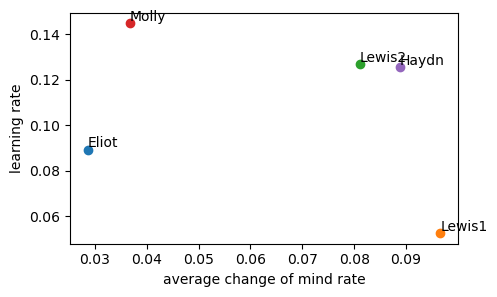

In [115]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3),sharex=True)
for k in ["Eliot","Lewis1","Lewis2","Molly","Haydn"]:
    x = com_rate_animals[k]
    y = -k_animals[k]
    ax1.scatter(x,y)
    ax1.text(x,y+0.001,k)
ax1.set_xlabel('average change of mind rate');
ax1.set_ylabel('learning rate');

### 2. Plot individual learning curves

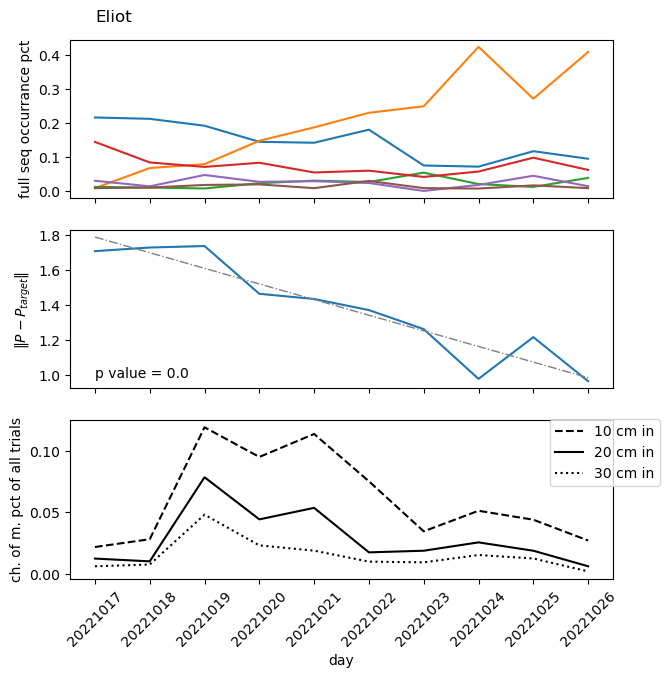

In [165]:
animal = "Eliot"

occurance_rates = occurance_rates_animals[animal]
total_trial_num = total_trial_num_animals[animal]
(trial_number1, trial_number2, trial_number3) = (trial_number_animals1[animal],
                                                 trial_number_animals2[animal],trial_number_animals3[animal]) # C-o-M trials

distances = distances_animals[animal]


fig, (ax1, ax3, ax2) = plt.subplots(3, 1, figsize=(7, 7),sharex=True)

ax1.plot([occurance_rates[k] for k in occurance_rates])
ax2.plot(np.array(trial_number1) / np.array([total_trial_num[k] for k in total_trial_num]),label = "10 cm in", color = 'k',linestyle = "dashed")
ax2.plot(np.array(trial_number2) / np.array([total_trial_num[k] for k in total_trial_num]),label = "20 cm in", color = 'k')
ax2.plot(np.array(trial_number3) / np.array([total_trial_num[k] for k in total_trial_num]),label = "30 cm in",color = 'k',linestyle = "dotted")
ax2.legend(bbox_to_anchor=(1.1, 1.05))

ax3.plot([distances[k] for k in distances])

y = distances_animals[animal]
x = np.arange(len(distances_animals[animal]))
results = results_animals[animal]
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
ax3.plot(x_plot,y_plot,color='grey',linewidth=1,linestyle = "-.")
ax3.text(np.min(x_plot),np.min(y_plot),f'p value = {np.round(pvalue_animals[animal],4)}')

ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('full seq occurrance pct');
ax2.set_ylabel('ch. of m. pct of all trials');
ax3.set_ylabel('$\|P - P_{target}\|$');

dates_to_plot = list(occurance_rates_animals[animal].keys())
ax2.set_xlabel('day');
ax2.set_xticks(np.arange(len(dates_to_plot)));
ax2.set_xticklabels(dates_to_plot, rotation = 45);

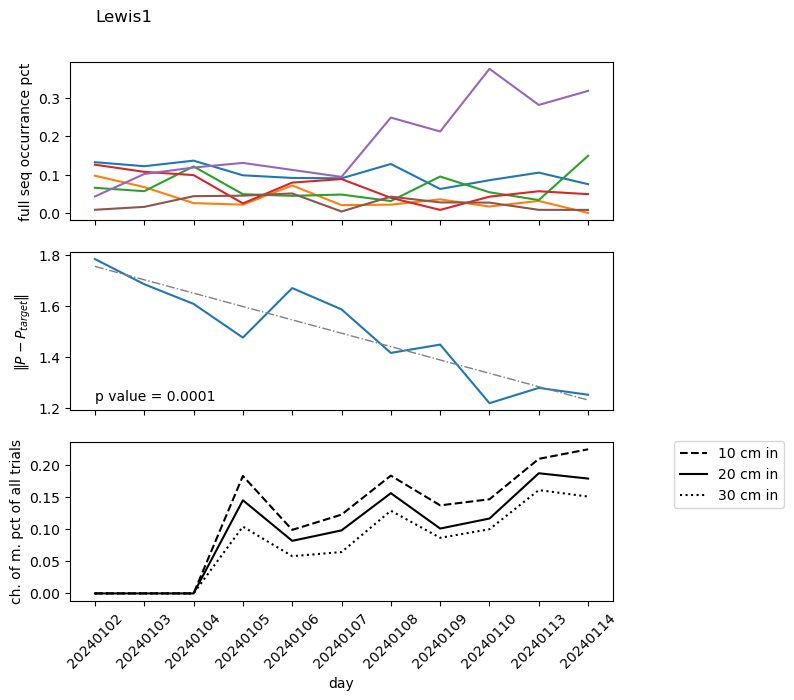

In [166]:
animal = "Lewis1"

occurance_rates = occurance_rates_animals[animal]
total_trial_num = total_trial_num_animals[animal]
(trial_number1, trial_number2, trial_number3) = (trial_number_animals1[animal],
                                                 trial_number_animals2[animal],trial_number_animals3[animal]) # C-o-M trials

distances = distances_animals[animal]


fig, (ax1, ax3, ax2) = plt.subplots(3, 1, figsize=(7, 7),sharex=True)

ax1.plot([occurance_rates[k] for k in occurance_rates])
ax2.plot(np.array(trial_number1) / np.array([total_trial_num[k] for k in total_trial_num]),label = "10 cm in", color = 'k',linestyle = "dashed")
ax2.plot(np.array(trial_number2) / np.array([total_trial_num[k] for k in total_trial_num]),label = "20 cm in", color = 'k')
ax2.plot(np.array(trial_number3) / np.array([total_trial_num[k] for k in total_trial_num]),label = "30 cm in",color = 'k',linestyle = "dotted")
ax2.legend(bbox_to_anchor=(1.1, 1.05))

ax3.plot([distances[k] for k in distances])

y = distances_animals[animal]
x = np.arange(len(distances_animals[animal]))
results = results_animals[animal]
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
ax3.plot(x_plot,y_plot,color='grey',linewidth=1,linestyle = "-.")
ax3.text(np.min(x_plot),np.min(y_plot),f'p value = {np.round(pvalue_animals[animal],4)}')

ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('full seq occurrance pct');
ax2.set_ylabel('ch. of m. pct of all trials');
ax3.set_ylabel('$\|P - P_{target}\|$');


dates_to_plot = list(occurance_rates_animals[animal].keys())
ax2.set_xlabel('day');
ax2.set_xticks(np.arange(len(dates_to_plot)));
ax2.set_xticklabels(dates_to_plot, rotation = 45);

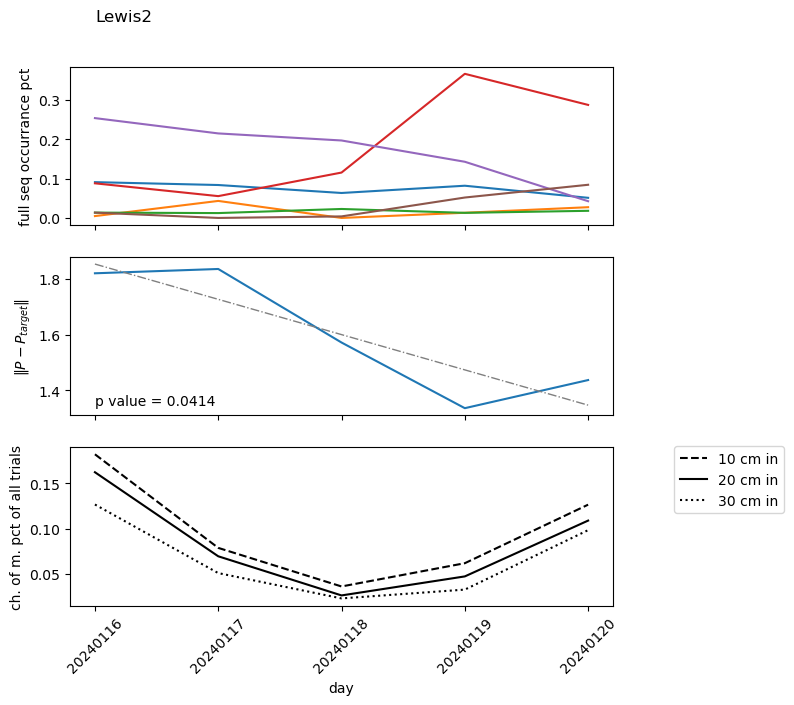

In [167]:
animal = "Lewis2"

occurance_rates = occurance_rates_animals[animal]
total_trial_num = total_trial_num_animals[animal]
(trial_number1, trial_number2, trial_number3) = (trial_number_animals1[animal],
                                                 trial_number_animals2[animal],trial_number_animals3[animal]) # C-o-M trials

distances = distances_animals[animal]


fig, (ax1, ax3, ax2) = plt.subplots(3, 1, figsize=(7, 7),sharex=True)

ax1.plot([occurance_rates[k] for k in occurance_rates])
ax2.plot(np.array(trial_number1) / np.array([total_trial_num[k] for k in total_trial_num]),label = "10 cm in", color = 'k',linestyle = "dashed")
ax2.plot(np.array(trial_number2) / np.array([total_trial_num[k] for k in total_trial_num]),label = "20 cm in", color = 'k')
ax2.plot(np.array(trial_number3) / np.array([total_trial_num[k] for k in total_trial_num]),label = "30 cm in",color = 'k',linestyle = "dotted")
ax2.legend(bbox_to_anchor=(1.1, 1.05))

ax3.plot([distances[k] for k in distances])

y = distances_animals[animal]
x = np.arange(len(distances_animals[animal]))
results = results_animals[animal]
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
ax3.plot(x_plot,y_plot,color='grey',linewidth=1,linestyle = "-.")
ax3.text(np.min(x_plot),np.min(y_plot),f'p value = {np.round(pvalue_animals[animal],4)}')

ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('full seq occurrance pct');
ax2.set_ylabel('ch. of m. pct of all trials');
ax3.set_ylabel('$\|P - P_{target}\|$');


dates_to_plot = list(occurance_rates_animals[animal].keys())
ax2.set_xlabel('day');
ax2.set_xticks(np.arange(len(dates_to_plot)));
ax2.set_xticklabels(dates_to_plot, rotation = 45);

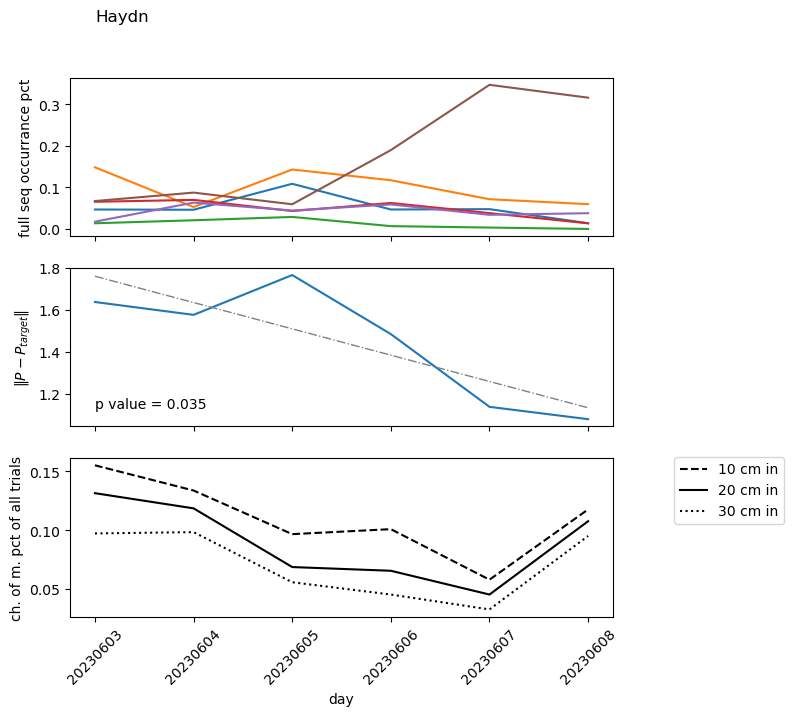

In [168]:
animal = "Haydn"

occurance_rates = occurance_rates_animals[animal]
total_trial_num = total_trial_num_animals[animal]
(trial_number1, trial_number2, trial_number3) = (trial_number_animals1[animal],
                                                 trial_number_animals2[animal],trial_number_animals3[animal]) # C-o-M trials

distances = distances_animals[animal]


fig, (ax1, ax3, ax2) = plt.subplots(3, 1, figsize=(7, 7),sharex=True)

ax1.plot([occurance_rates[k] for k in occurance_rates])
ax2.plot(np.array(trial_number1) / np.array([total_trial_num[k] for k in total_trial_num]),label = "10 cm in", color = 'k',linestyle = "dashed")
ax2.plot(np.array(trial_number2) / np.array([total_trial_num[k] for k in total_trial_num]),label = "20 cm in", color = 'k')
ax2.plot(np.array(trial_number3) / np.array([total_trial_num[k] for k in total_trial_num]),label = "30 cm in",color = 'k',linestyle = "dotted")
ax2.legend(bbox_to_anchor=(1.1, 1.05))

ax3.plot([distances[k] for k in distances])

y = distances_animals[animal]
x = np.arange(len(distances_animals[animal]))
results = results_animals[animal]
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
ax3.plot(x_plot,y_plot,color='grey',linewidth=1,linestyle = "-.")
ax3.text(np.min(x_plot),np.min(y_plot),f'p value = {np.round(pvalue_animals[animal],4)}')

ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('full seq occurrance pct');
ax2.set_ylabel('ch. of m. pct of all trials');
ax3.set_ylabel('$\|P - P_{target}\|$');


dates_to_plot = list(occurance_rates_animals[animal].keys())
ax2.set_xlabel('day');
ax2.set_xticks(np.arange(len(dates_to_plot)));
ax2.set_xticklabels(dates_to_plot, rotation = 45);

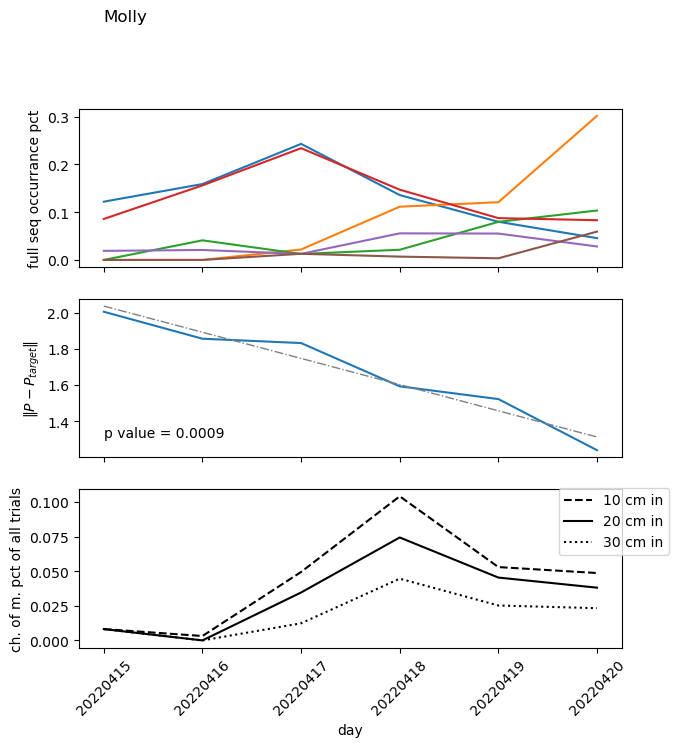

In [169]:
animal = "Molly"

occurance_rates = occurance_rates_animals[animal]
total_trial_num = total_trial_num_animals[animal]
(trial_number1, trial_number2, trial_number3) = (trial_number_animals1[animal],
                                                 trial_number_animals2[animal],trial_number_animals3[animal]) # C-o-M trials

distances = distances_animals[animal]


fig, (ax1, ax3, ax2) = plt.subplots(3, 1, figsize=(7, 7),sharex=True)

ax1.plot([occurance_rates[k] for k in occurance_rates])
ax2.plot(np.array(trial_number1) / np.array([total_trial_num[k] for k in total_trial_num]),label = "10 cm in", color = 'k',linestyle = "dashed")
ax2.plot(np.array(trial_number2) / np.array([total_trial_num[k] for k in total_trial_num]),label = "20 cm in", color = 'k')
ax2.plot(np.array(trial_number3) / np.array([total_trial_num[k] for k in total_trial_num]),label = "30 cm in",color = 'k',linestyle = "dotted")
ax2.legend(bbox_to_anchor=(1.1, 1.05))

ax3.plot([distances[k] for k in distances])


y = distances_animals[animal]
x = np.arange(len(distances_animals[animal]))
results = results_animals[animal]
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
ax3.plot(x_plot,y_plot,color='grey',linewidth=1,linestyle = "-.")
ax3.text(np.min(x_plot),np.min(y_plot),f'p value = {np.round(pvalue_animals[animal],4)}')

ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('full seq occurrance pct');
ax2.set_ylabel('ch. of m. pct of all trials');
ax3.set_ylabel('$\|P - P_{target}\|$');


dates_to_plot = list(occurance_rates_animals[animal].keys())
ax2.set_xlabel('day');
ax2.set_xticks(np.arange(len(dates_to_plot)));
ax2.set_xticklabels(dates_to_plot, rotation = 45);

# End here

In [98]:
animal = 'Lewis'
dates_to_plot = ['20240102','20240103','20240104','20240105','20240106','20240107','20240108','20240109',
                 '20240110','20240113','20240114','20240115','20240116','20240117','20240118','20240119','20240120']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

animal = 'Haydn'
dates_to_plot = ['20230603','20230604','20230605','20230606','20230607','20230608']
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

animal = 'Molly'
dates_to_plot = ['20220415','20220416','20220417','20220418','20220419','20220420']
datafolder = f'/stelmo/shijie/behavior_pilot/Batch1/{animal}'

In [6]:
trials_days = find_trials_animal(animal,dates_to_plot)

[09:51:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[09:51:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[09:51:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[09:51:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[09:51:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[09:51:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[09:51:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[09:51:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[09:51:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[09:51:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[09:51:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[09:51:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[09:51:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[09:51:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[09:51:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[09:51:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Rev3Session6
pos 11 valid times


[09:51:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[09:51:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[09:51:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[09:51:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[09:51:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[09:51:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[09:51:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[09:51:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[09:51:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[09:51:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Rev3Session5
pos 10 valid times


[09:51:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[09:51:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[09:51:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[09:51:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[09:51:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


In [7]:
# do some sum across sessions within day
trial_number = []
for k in trials_days:
    trial_number.append(np.sum([len(trial) for trial in trials_days[k]]))

In [8]:
# load behavior data

sequence_datapath = os.path.join(datafolder,'behavior_metaSequence_'+animal+'.p')
with open(sequence_datapath, 'rb') as f:
    behavior_data = pickle.load(f)  

In [9]:
total_trial_num = {}
occurance_rates = {}

for day in dates_to_plot:
    total_trial_num_day = 0
    occurance_rates_day = np.zeros(6)
    
    subset_ind = np.argwhere(behavior_data['dateIntAll'] == int(day)).ravel()
    for session_ind in subset_ind:
        total_trial_num_day = total_trial_num_day + len(behavior_data['outersAll'][session_ind])
        for seq in range(6):
            occurance_rates_day[seq] = occurance_rates_day[seq] + np.mean(behavior_data['occurance_rates'][seq][session_ind])
    occurance_rates_day = occurance_rates_day/len(subset_ind)
    
    total_trial_num[day] = total_trial_num_day
    occurance_rates[day] = occurance_rates_day

### plots

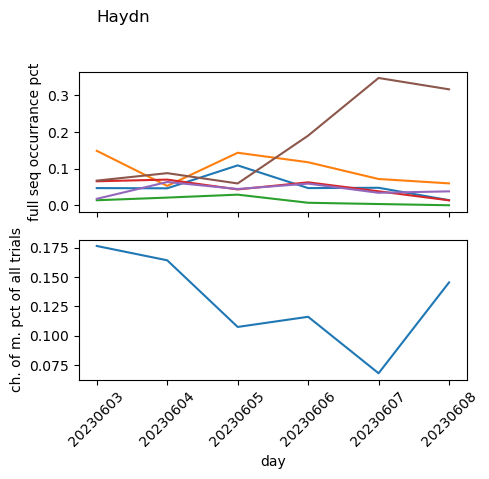

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4),sharex=True)

ax1.plot([occurance_rates[k] for k in occurance_rates])
ax2.plot(np.array(trial_number) / np.array([total_trial_num[k] for k in total_trial_num]))

ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('full seq occurrance pct');
ax2.set_ylabel('ch. of m. pct of all trials');
ax2.set_xlabel('day');
ax2.set_xticks(np.arange(len(dates_to_plot)));
ax2.set_xticklabels(dates_to_plot, rotation = 45);